In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

Q1.1 Using cancer data to proceed Logistic Regression.

In [127]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [128]:
cancer = load_breast_cancer(as_frame = True)

cancer_data = cancer['data']
cancer_target = cancer['target']
cancer_feature_name = cancer['feature_names']
cancer_names_target = cancer['target_names']


In [129]:
cancer_data_train,cancer_data_test,cancer_target_train,cancer_target_test  = \
    train_test_split(cancer_data, cancer_target,test_size=0.2,random_state=123)

In [130]:
cancer_data_train = pd.DataFrame(data = cancer_data_train, columns = cancer_feature_name)
cancer_data_test = pd.DataFrame(data = cancer_data_test, columns = cancer_feature_name)

Select the high variance column:
I suppose that only the column with high variance can provide enough information for model to recognize the label

In [131]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

def fs_variance(df, threshold):

    features = list(df.columns)
    vt = VarianceThreshold(threshold = threshold)
    _ = vt.fit(df)

    feat_select = list(compress(features, vt.get_support()))
    return feat_select

train_list = fs_variance(cancer_data_train, 0.85)
test_list = fs_variance(cancer_data_test, 0.85)
cancer_data_train_op = cancer_data_train[train_list]
cancer_data_test_op = cancer_data_test[test_list]

Analysis the correlation between features

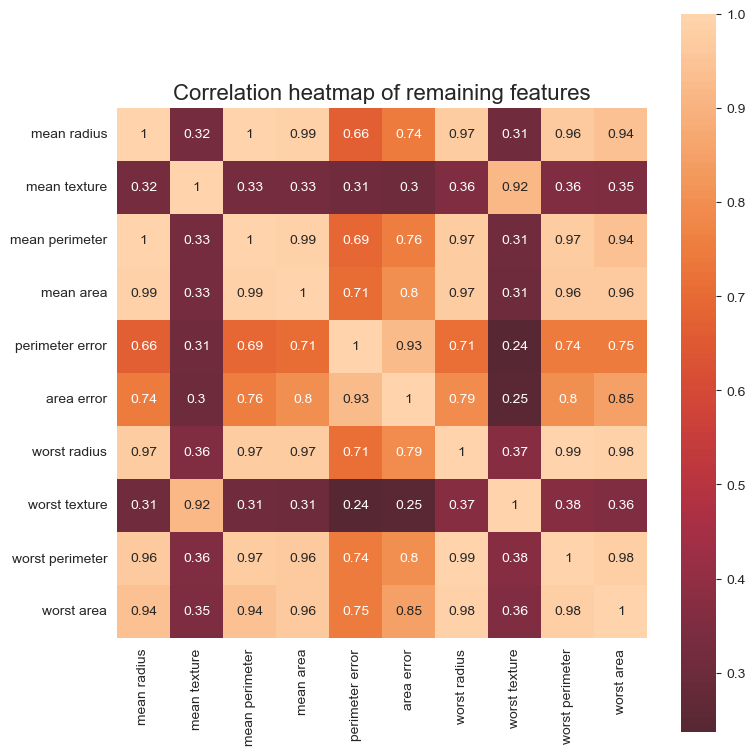

In [132]:
import seaborn as sns

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
shifted_cols = cancer_data_train_op.columns
corr_mat = cancer_data_train_op[shifted_cols].corr()

heat_map = sns.heatmap(corr_mat, center = 0, annot = True, square = True)
ax.set_title('Correlation heatmap of remaining features', fontsize=16)
plt.tight_layout()
plt.show()

From above diagram, it can be shown clearly that the feature 'mean texture' and 'worst texture' have the least correlation with other features. As a result, I can remove them from the training set since their relation with others is not strong enough

In [133]:
cancer_data_train_op = cancer_data_train_op.drop(columns = ['mean texture', 'worst texture'])
cancer_data_test_op = cancer_data_test_op.drop(columns = ['mean texture', 'worst texture'])

Proceeding Logistic Regression

In [134]:
from sklearn.metrics import classification_report

def sk_train(train_X, train_y):
    sk_lg = LogisticRegression()
    sk_lg.fit(train_X, train_y)

    return sk_lg

def test(test_X, test_y, sk_lg):
    pred_y = sk_lg.predict(test_X)

    return classification_report(test_y, pred_y)

sk_lg = sk_train(cancer_data_train_op, cancer_target_train)
print(test(cancer_data_test_op, cancer_target_test, sk_lg))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        41
           1       0.97      0.99      0.98        73

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



/Users/ce1ebratechen/opt/anaconda3/envs/Newpython/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Q2. Compare the whole-data result and partial-data result & Experiment to prove the effect of above operation

In [135]:
sk_lg = sk_train(cancer_data_train, cancer_target_train)
print(test(cancer_data_test, cancer_target_test, sk_lg))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        41
           1       0.97      1.00      0.99        73

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



/Users/ce1ebratechen/opt/anaconda3/envs/Newpython/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Above result showed that there is not a clear difference between training with 8 features after selection and all of 30 features, which means the 8 features I select already contain most of the information in the data.

The reason why the over all feature set have higher score than selected one might because of the information contain in other 22 features.





Next step is compare different combination of features with combination I select in the same size

In [136]:
cancer_data_train = np.array(cancer_data_train)
cancer_data_test = np.array(cancer_data_test)
cancer_target_train = np.array(cancer_target_train).reshape((cancer_target_train.shape[0], 1)).ravel()
cancer_target_test = np.array(cancer_target_test).reshape((cancer_target_test.shape[0], 1)).ravel()

In [ ]:
score_list = []
feature_list = []

for i in range(11):
    random_features = np.random.choice(30, 8, replace = False)
    cancer_data_train_temp = cancer_data_train[:, random_features]
    cancer_data_test_temp = cancer_data_test[:, random_features]
    sk_lg_temp = sk_train(cancer_data_train_temp, cancer_target_train)
    score = sk_lg_temp.score(cancer_data_test_temp, cancer_target_test)
    score_list.append(score)
    random_features = i + 1
    feature_list.append(random_features)

In [ ]:
score_list = np.array(score_list)
feature_list = np.array(feature_list)
data = np.column_stack([feature_list, score_list])
data = pd.DataFrame(data = data, columns = ['combination', 'score'])
data

In [ ]:
sk_lg = sk_train(cancer_data_train_op, cancer_target_train)
op_score = sk_lg.score(cancer_data_test_op, cancer_target_test)

In [140]:
data.loc[data.shape[0]] = ['selected', op_score]

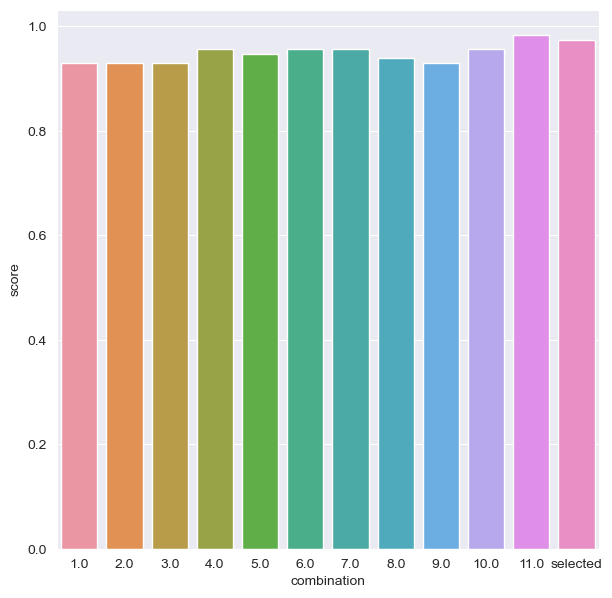

In [141]:
import seaborn as sns

plt.figure(figsize = (7, 7))
sns.barplot(x = 'combination', y = 'score', data = data)
plt.show()

It can be obviously seen that the score calculated by sklearn-owned criteria described before of selected combination have a high rank among the other 10 random chosen combinations.
Considering the goodness of the dataset provided by sklearn, it is reasonable to choose some high variance and high correlation features in dataset.

Q3 Compare result from Q2 and result from first 200, 400 pieces of dataset

In [142]:
first_200_train = cancer_data_train[0 : 200, :]
first_200_target = cancer_target_train[0 : 200]

In [143]:
sk_lg_200 = sk_train(first_200_train, first_200_target)
print(classification_report(cancer_target_test, sk_lg_200.predict(cancer_data_test)))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        41
           1       0.97      1.00      0.99        73

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



/Users/ce1ebratechen/opt/anaconda3/envs/Newpython/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [144]:
first_400_train = cancer_data_train[0 : 400, :]
first_400_target = cancer_target_train[0 : 400]

In [145]:
sk_lg_400 = sk_train(first_400_train, first_400_target)
print(classification_report(cancer_target_test, sk_lg_400.predict(cancer_data_test)))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        41
           1       0.97      1.00      0.99        73

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



/Users/ce1ebratechen/opt/anaconda3/envs/Newpython/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Through the result shown above, there is no significant or major difference between training with first 200 data and first 400 data

Q4. Relationship between input feature and result and between input datasize and result

Since from Q3, first 200 and first 400 do not exist major difference between them, for the sake of clarity it is necessary to reduce the size of input dataset continuously. And draw a diagram to describe the relation between input datasize and performance of result.

First, create a new criteria considering accuracy F1 score, precession and score. All output of them is range from 0-1, so it is possible to add them up

In [146]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

def my_criteria(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    return (f1 + pre + recall + acc) / 4

Next, given a list range from 0-455(size of training set), calculate the score of each model training from the training set which size increase 1 per iteration.
However, since the solver must start with 2 kinds of label and the first 1 comes up at the third place which is too small to have a effect on the relationship result, the start size of the diagram is set as 3

In [ ]:
size = list(range(3, 456))
score_list = []

for i in size:
    train_data = cancer_data_train[0 : i, :]
    train_target = cancer_target_train[0 : i]
    sk_lg_size = sk_train(train_data, train_target)
    y_pred_temp = sk_lg_size.predict(cancer_data_test)
    score_list.append(my_criteria(cancer_target_test, y_pred_temp))

Plot the graph

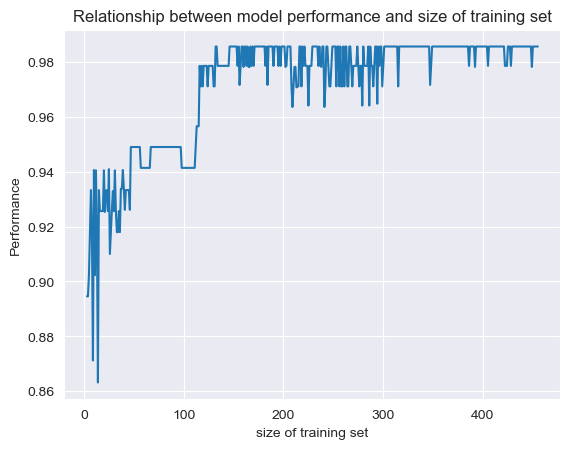

In [148]:
plt.figure()
plt.plot(size, score_list)
plt.xlabel('size of training set')
plt.ylabel('Performance')
plt.title('Relationship between model performance and size of training set')
plt.show()

When the size of training set is 3, the performance of data could also approach a value of 0.87. In this case, the training set only contains two '0' label and one '1' label, nonetheless it also showed a good result on test set. So I wonder whether model could still predict '1' on test set even though there is no '0' label on training set

In [149]:
def sigmoid(z):
    return 1 / (1 + np.exp(- z))

def cost(theta, X, y):
    a = y * np.log(sigmoid(X @ theta))
    b = (1 - y) * np.log(1 - sigmoid(X @ theta))

    return np.mean(-(a + b))


def gradient(theta, X, y):

    return (X.T @ (sigmoid(X @ theta) - y)) / (X.shape[0])


def prediction(theta,X):
    probability = sigmoid(X @ theta)
    return [1 if x >= 0.5 else 0 for x in probability]


Train with only one piece of data and only exist one label '0'

In [156]:
import scipy.optimize as opt

theta = np.zeros(cancer_data_train.shape[1])
theta, eval_num, _ = opt.fmin_tnc(func = cost, x0 = theta, fprime = gradient, args =
(cancer_data_train[0 : 1, :], cancer_target_train[0 : 1]))


score = my_criteria(cancer_target_test, prediction(theta, cancer_data_test))
print(f'my_criteria score: {score}')

my_criteria score: 0.08991228070175439


  NIT   NF   F                       GTG
    0    1  6.931471805599453E-01   2.44210642E+05
tnc: fscale = 0.00202357
    1    3  1.269280110319908E-01   1.38802848E+04
    2    6  1.489221864503759E-04   2.16610103E-02
tnc: fscale = 6.79455
    3    9  3.688224331082650E-07   1.32879833E-07
tnc: fscale = 2743.28
    4   12  9.141765126856319E-10   8.16365674E-13
tnc: |pg| = 3.29361e-10 -> local minimum
    4   12  9.141765126856319E-10   8.16365674E-13
tnc: Local minima reach (|pg| ~= 0)
/Users/ce1ebratechen/opt/anaconda3/envs/Newpython/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train with two pieces of data and only exist one kind of label '0'

In [157]:
theta = np.zeros(cancer_data_train.shape[1])
theta, eval_num, _ = opt.fmin_tnc(func = cost, x0 = theta, fprime = gradient, args =
(cancer_data_train[0 : 2, :], cancer_target_train[0 : 2]))

print(f'my_criteria score: {my_criteria(cancer_target_test, prediction(theta, cancer_data_test))}')

my_criteria score: 0.08771929824561403


  NIT   NF   F                       GTG
    0    1  6.931471805599453E-01   5.31346461E+05
tnc: fscale = 0.00137186
    1    4  1.269280046133477E-01   3.02003229E+04
    2    7  1.489222848749237E-04   4.71294768E-02
tnc: fscale = 4.60632
    3   11  3.688157416250943E-07   2.89098812E-07
tnc: fscale = 1859.85
    4   15  9.141418182160806E-10   1.77600245E-12
tnc: fscale = 750375
tnc: |fn-fn-1] = 9.11876e-10 -> convergence
    5   19  2.265798659808818E-12   1.09103947E-17
tnc: Converged (|f_n-f_(n-1)| ~= 0)


The result from 1 piece and 2 pieces of data show a bad performance on test set which is quite reasonable, for the reason that I only provide one kind of label information during the training process, making it difficult to identify the other kind of label '1' in test set.